## <center> Book Imblance Signal

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('expand_frame_repr', False)
from sklearn.metrics import (confusion_matrix, classification_report, log_loss)

We next define our **predictor**, **order book imbalance** $ I $, as
$$
    I = \frac{Q_b}{Q_b + Q_a}, \quad I \in [0, 1].
$$
This provides a continuous measure of the imbalance between bids and asks at the closest price levels. If $ I $ is close to 1, there are significantly more bids than asks at the best bid price $ P_b \implies$ strong buying pressure. Conversely, if $ I $ is close to 0, there are significantly more asks than bids at the best ask price $ P_a \implies$ strong selling pressure.


In [8]:
# Load data
book_paths = [
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_book_20240418.pkl",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_book_20240419.pkl"
]
book_list = [pd.DataFrame(pd.read_pickle(path)) for path in book_paths]
book = pd.concat(book_list, ignore_index=True)

# Best bids and asks
Pb = np.array([float(book['levels'][i][0][0]['price']) for i in range(len(book))])
Pa = np.array([float(book['levels'][i][1][0]['price']) for i in range(len(book))])

# Corresponding volumes
Qb = np.array([float(book['levels'][i][0][0]['size']) for i in range(len(book))])
Qa = np.array([float(book['levels'][i][1][0]['size']) for i in range(len(book))])

We define the **dependent variable**, the **price movement direction** $y$, as

$$
y = 
\begin{cases} 
1, & \text{if the price increases}, \\ 
0, & \text{if the price decreases},\\
\end{cases}
$$
ignoring the case for the price staying the same. This variable is based on future mid-price changes over a $h = 3$-second horizon. The predictor, **extreme imbalance**, is defined as
- A **high imbalance** occurs when $I \geq I_{95\%}$.
- A **low imbalance** occurs when $I \leq I_{5\%}$.

We therefore define the **extreme imbalance indicator** as

$$
I_\mathcal{E} = 
\begin{cases} 
1, & \text{if high imbalance}, \\
-1, & \text{if low imbalance}, \\
0, & \text{otherwise}.
\end{cases}
$$

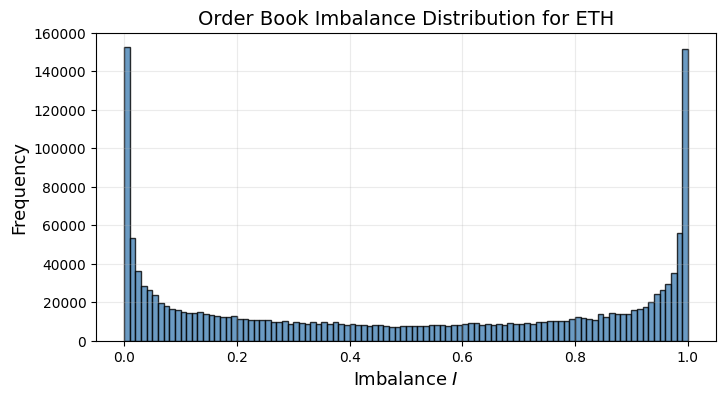

In [16]:
# Calculate variables
mid = (Pa + Pb) / 2
book_time = pd.to_datetime(book['timestamp'], unit='ms')

# Order book imbalance I
I = np.where(Qb + Qa != 0, Qb / (Qb + Qa), 0)

# Create a dataframe
df = pd.DataFrame({'time': book_time, 'mid': mid, 'I': I})
df.set_index('time', inplace=True)

# Plot the distribution of imbalance
plt.figure(figsize=(8, 4))
plt.hist(df['I'], label='Order Book Imbalance', color='steelblue', bins=100, alpha=0.8, edgecolor='black')
plt.title('Order Book Imbalance Distribution for ETH', fontsize=14)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel(r'Imbalance $I$', fontsize=13)
plt.grid(alpha=0.25)
plt.show()

In [24]:
# Define time horizon h in seconds; adjust for 0.1-second updates
h = 3
df_s = df.resample('1s').last().dropna()

# Calculate future mid-price based on the 1-second updates
df_s['mid_future'] = df_s['mid'].shift(-h)
df_s.dropna(inplace=True)

# Create binary dependent variable: 1 if price goes up, 0 if price goes down
df_s['price_direction'] = np.where(df_s['mid_future'] > df_s['mid'], 1, 0)

# Define thresholds for extreme imbalance
high_threshold = df_s['I'].quantile(0.95)
low_threshold = df_s['I'].quantile(0.05)

# Create an indicator for extreme imbalance
df_s['extreme_imbalance'] = 0
df_s.loc[df_s['I'] >= high_threshold, 'extreme_imbalance'] = 1  # High imbalance
df_s.loc[df_s['I'] <= low_threshold, 'extreme_imbalance'] = -1  # Low imbalance

# Filter data to only include extreme imbalance observations
extreme_df = df_s[df_s['extreme_imbalance'] != 0]

# Recode 'price_direction' for binary classification (1 for upwards, 0 for downwards)
extreme_df_copy = extreme_df.copy()

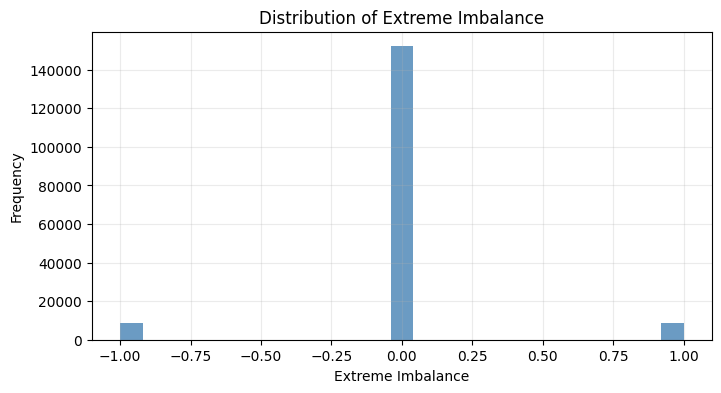

In [25]:
# Plot distribution of extreme imbalance
plt.figure(figsize=(8, 4))
plt.hist(df_s['extreme_imbalance'], bins=25, color='steelblue', alpha=0.8)
plt.title('Distribution of Extreme Imbalance')
plt.xlabel('Extreme Imbalance')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

The majority of observations fall into neutral territory, meaning that for the most time, the order book is in balance.

But the rare extreme imbalances are precisely the conditions we are interested in for predicting price movements. Even though these cases are infrequent, they are likely to be more predictive of significant price movements. The logistic regression model is thus focused on these extremes, where market pressure is imbalanced enough to lead to substantial price changes.

### Logistic Regression
We use a logistic regression model to predict price movement direction based on extreme imbalance, as the dependent variable $y$ is binary.

The model estimates the probability of an upward movement given the extreme imbalance indicator $I_\mathcal{E}$, using the log-odds function

$$
    \log \frac{\mathbb{P}(y = 1 \mid I_\mathcal{E})}{1 - \mathbb{P}(y = 1 \mid I_\mathcal{E})} = \beta_0 + \beta_1 I_\mathcal{E}
$$

where $P(y = 1 \mid I_\mathcal{E})$ is the probability of upward movement, $\beta_0$ is the intercept, and $\beta_1$ is the coefficient for the imbalance indicator.

In [26]:
# Prepare data for binary logistic regression
X_extreme = extreme_df_copy[['extreme_imbalance']]
y_extreme = extreme_df_copy['price_direction']

# Add constant term for intercept
X_extreme = sm.add_constant(X_extreme)

# Perform binary logistic regression
model_binary = sm.Logit(y_extreme, X_extreme)
results_binary = model_binary.fit()

# Print the regression results
print("Binary Logistic Regression Results:")
print(results_binary.summary())

Optimization terminated successfully.
         Current function value: 0.477114
         Iterations 6
Binary Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:        price_direction   No. Observations:                16906
Model:                          Logit   Df Residuals:                    16904
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                  0.2970
Time:                        10:43:57   Log-Likelihood:                -8066.1
converged:                       True   LL-Null:                       -11475.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5587      0.021    -26.768      0.

The log-likelihood of $-8066.1$ compared to the null model's $-11475.$ suggests a significant improvement in fit, with a pseudo $R^2 = 1 - \frac{\text{LL}}{\text{LL}_{\text{Null}}} = 0.2970 \implies$ the model explains $29.7\%$ of the variability in price direction.

The coefficient for the extreme imbalance $I_\mathcal{E}$ is $1.4809$, with a standard error of $0.021$. The large $z$-value of $z = \frac{1.4809}{0.021} = 70.951 \gg 0$ and p-value of $0$ confirm that extreme imbalance is highly significant in predicting price movement. 

A positive coefficient indicates that a higher imbalance increases the likelihood of upward movement ($y = 1$). The intercept of $-0.5587$ suggests that without imbalance, the probability of upward movement is less than 0.3845.

In [27]:
# Define the input extreme imbalance values for prediction
extreme_I = [1, -1]  # Only cases we need to compute the probabilities since we ignore 0

# Log-odds for upward and downward price movement
log_odds = [results_binary.params['const'] + results_binary.params['extreme_imbalance'] * X for X in extreme_I]

# Calculate probabilities for upward and downward movement
upward = 1/ (1 + np.exp(-log_odds[0]))
downward = 1 - 1 / (1 + np.exp(-log_odds[1]))

# Print the calculated probabilities
print(f"P(upwards|I = 1) = {upward:.4f}")
print(f"P(downwards|I = -1) = {downward:.4f}")

P(upwards|I = 1) = 0.7155
P(downwards|I = -1) = 0.8849


The logistic function converts the log-odds into a probability
$$
    \mathbb{P}(y \mid I_\mathcal{E}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 I_\mathcal{E})}},
$$
where we see that the probability of the price moving up, given high imbalance is
$$
    \mathbb{P}(y = 1 \mid  I_\mathcal{E} = 1) = 0.7155
$$
and the probability of the price moving down, given low imbalance is
$$
    \mathbb{P}(y = 0 \mid  I_\mathcal{E} = -1) = 0.8849.
$$

### <center> Out of Sample Prediction

In [29]:
book_ous = pd.DataFrame(pd.read_pickle("C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_book_20240420.pkl"))

In [30]:
# Best bids and asks
Pb_ous = np.array([float(book_ous['levels'].iloc[i][0][0]['price']) for i in range(len(book_ous))])
Pa_ous = np.array([float(book_ous['levels'].iloc[i][1][0]['price']) for i in range(len(book_ous))])

# Corresponding volumes
Qb_ous = np.array([float(book_ous['levels'].iloc[i][0][0]['size']) for i in range(len(book_ous))])
Qa_ous = np.array([float(book_ous['levels'].iloc[i][1][0]['size']) for i in range(len(book_ous))])

In [ ]:
# Variables
mid_ous = (Pa_ous + Pb_ous) / 2
I_ous = np.where(Qb_ous + Qa_ous != 0, Qb_ous / (Qb_ous + Qa_ous), 0)

df_ous = pd.DataFrame({'time': pd.to_datetime(book_ous['timestamp'], unit='ms'), 'mid': mid_ous, 'I': I_ous})
df_ous.set_index('time', inplace=True)

df_ous_s = df_ous.resample('1s').last().dropna()

df_ous_s['mid_future'] = df_ous_s['mid'].shift(-h)
df_ous_s.dropna(inplace=True)

# 1 if price goes up and 0 if price goes down
df_ous_s['price_direction'] = np.where(df_ous_s['mid_future'] > df_ous_s['mid'], 1, 0)

# Thresholds
df_ous_s['extreme_imbalance'] = 0
df_ous_s.loc[df_ous_s['I'] >= high_threshold, 'extreme_imbalance'] = 1  # High imbalance
df_ous_s.loc[df_ous_s['I'] <= low_threshold, 'extreme_imbalance'] = -1  # Low imbalance

extreme_ous_df = df_ous_s[df_ous_s['extreme_imbalance'] != 0].copy()

# Prepare data for prediction (same structure as training data)
X_ous = extreme_ous_df[['extreme_imbalance']]
X_ous = sm.add_constant(X_ous)

# Use the trained model to predict on the out-of-sample data
predictions_ous = results_binary.predict(X_ous)

# Add predicted probabilities to the out-of-sample dataframe
extreme_ous_df['predicted_prob'] = predictions_ous

# Evaluate the out-of-sample performance
extreme_ous_df['predicted_direction'] = np.where(extreme_ous_df['predicted_prob'] > 0.5, 1, 0)

Out-of-sample accuracy: 0.8331


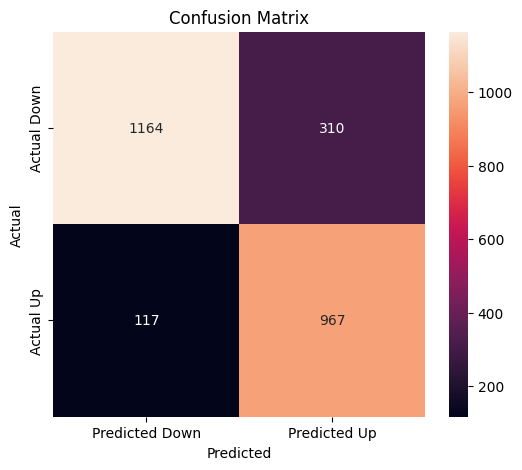

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1474
           1       0.76      0.89      0.82      1084

    accuracy                           0.83      2558
   macro avg       0.83      0.84      0.83      2558
weighted avg       0.84      0.83      0.83      2558

Out-of-sample accuracy: 0.8331
Log Loss = 0.4334


In [ ]:
# Model evaluation

# Confusion matrix
cm = confusion_matrix(extreme_ous_df['price_direction'], extreme_ous_df['predicted_direction'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Down', 'Predicted Up'], yticklabels=['Actual Down', 'Actual Up'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(f"Classification Report\n{classification_report(extreme_ous_df['price_direction'], extreme_ous_df['predicted_direction'])}")

# Accuracy
accuracy = np.mean(extreme_ous_df['predicted_direction'] == extreme_ous_df['price_direction'])
print(f"Out-of-sample accuracy: {accuracy:.4f}")

# Log loss
ll = log_loss(extreme_ous_df['price_direction'], extreme_ous_df['predicted_prob'])
print(f"Log loss = {ll:.4f}")